# EECE5644 Assignment 2

Going over "solutions" for Assignment 2.

## Imports

In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

from sys import float_info  # Threshold smallest positive floating value

from math import ceil, floor 

import matplotlib.pyplot as plt # For general plotting

import numpy as np

from scipy.optimize import minimize
from scipy.stats import multivariate_normal as mvn

from sklearn.preprocessing import PolynomialFeatures

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

## Data-Generating Functions

> The trick with generating the dataset for <b>Q1</b> was to realize that class 0 is in fact distributed according to a Gaussian Mixture Model (GMM), with $a_1$ and $a_2$ acting as mixture coefficients/weights. Because $a_1=a_2$ does NOT mean there will necessarily be the same number of samples drawn from the first and second components of the class 0 conditional PDF. Instead, you are assigning samples via probability, as determined by the weighted prior for class 0. Please refer to the below code as one example of how to implement this data-generating method. 

> You could also separately draw samples from a GMM for class 0 and then a multivariate Gaussian for class 1, using the specified parameters.

In [2]:
def generate_q1_data(N, pdf_params):
    # Determine dimensionality from PDF parameters
    n = pdf_params['mu'].shape[1]

    # Decide randomly which samples will come from each Gaussian u_i ~ Uniform(0, 1) for i in {1, ..., N}
    u = np.random.rand(N)
    # Determine the thresholds based on the mixture weights/priors for the GMM, which need to sum up to 1
    # Note how the samples from class 0 are weighted according to the mixture coefficients 'a' and THEN
    # the class prior probabilities contribute to how these pools are labelled... 
    # Try fiddling about with a_1 and a_2 to see the effects on the dataset generated (noting Class 0 samples)
    thresholds = np.cumsum(np.append(pdf_params['gmm_a'].dot(pdf_params['priors'][0]), pdf_params['priors'][1]))
    thresholds = np.insert(thresholds, 0, 0) # For intervals of classes

    # Only 2 classes so can rely on single boolean condition to label samples
    labels = u >= pdf_params['priors'][0]
    X = np.zeros((N, n))
    num_gaussians = len(pdf_params['mu'])
    for i in range(1, num_gaussians+1):
        # Get randomly sampled indices for this Gaussian, checking between thresholds based on class priors
        indices = np.argwhere((thresholds[i-1] <= u) & (u <= thresholds[i]))[:, 0]
        X[indices, :] =  mvn.rvs(pdf_params['mu'][i-1], pdf_params['Sigma'][i-1], len(indices))

    return X, labels

In [3]:
def generate_q2_data(N, dataset_name):
    gmm_pdf = {}
    gmm_pdf['priors'] = np.array([.3, .4, .3])
    gmm_pdf['mu'] = np.array([[-10, 0, 10], [0, 0, 0], [10, 0, -10]])  # Gaussian distributions means
    gmm_pdf['Sigma'] = np.array([[[1, 0, -3], [0, 1, 0], [-3, 0, 15]], [[8, 0, 0], [0, .5, 0], [0, 0, .5]],
                                 [[1, 0, -3], [0, 1, 0], [-3, 0, 15]]])  # Gaussian distributions covariance matrices

    X, y = generate_gmm_data(N, gmm_pdf)

    # Plot the original data and their true labels
    fig = plt.figure(figsize=(10, 10))

    ax_raw = fig.add_subplot(111, projection='3d')

    ax_raw.scatter(X[:, 0], X[:, 1], y, marker='o', color='b')
    ax_raw.set_xlabel(r"$x_1$")
    ax_raw.set_ylabel(r"$x_2$")
    ax_raw.set_zlabel(r"$y$")
    # Set equal axes for 3D plots
    ax_raw.set_box_aspect((np.ptp(X[:, 0]), np.ptp(X[:, 1]), np.ptp(y)))

    plt.title("{} Dataset".format(dataset_name))
    plt.tight_layout()
    plt.show()

    return X, y


def generate_gmm_data(N, gmm_pdf):
    # Generates N vector samples from the specified mixture of Gaussians
    # Returns samples and their component labels
    # Data dimensionality is determined by the size of mu/Sigma parameters

    # Decide randomly which samples will come from each component
    u = np.random.random(N)
    thresholds = np.cumsum(gmm_pdf['priors'])
    thresholds = np.insert(thresholds, 0, 0)  # For intervals of classes

    n = gmm_pdf['mu'].shape[0]  # Data dimensionality

    X = np.zeros((N, n))
    C = len(gmm_pdf['priors'])  # Number of components
    for i in range(C + 1):
        # Get randomly sampled indices for this Gaussian, checking between thresholds based on class priors
        indices = np.argwhere((thresholds[i - 1] <= u) & (u <= thresholds[i]))[:, 0]
        # No. of samples in this Gaussian
        X[indices, :] = mvn.rvs(gmm_pdf['mu'][i - 1], gmm_pdf['Sigma'][i - 1], len(indices))

    return X[:, 0:2], X[:, 2]

## Evaluation Functions

> Copied over from [Assignment 1](hw1.ipynb). Also includes a utility function that creates a grid (matrix) of prediction scores, e.g., ERM discriminant or logistic prediction scores.

In [4]:
# Generate ROC curve samples
def estimate_roc(discriminant_score, labels, N_labels):
    # Sorting necessary so the resulting FPR and TPR axes plot threshold probabilities in order as a line
    sorted_score = sorted(discriminant_score)

    # Use gamma values that will account for every possible classification split
    # The epsilon is just to account for the two extremes of the ROC curve (TPR=FPR=0 and TPR=FPR=1)
    gammas = ([sorted_score[0] - float_info.epsilon] +
              sorted_score +
              [sorted_score[-1] + float_info.epsilon])

    # Calculate the decision label for each observation for each gamma
    decisions = [discriminant_score >= g for g in gammas]
    
    # Retrieve indices where FPs occur
    ind10 = [np.argwhere((d == 1) & (labels == 0)) for d in decisions]
    # Compute FP rates (FPR) as a fraction of total samples in the negative class
    p10 = [len(inds) / N_labels[0] for inds in ind10]
    # Retrieve indices where TPs occur
    ind11 = [np.argwhere((d == 1) & (labels == 1)) for d in decisions]
    # Compute TP rates (TPR) as a fraction of total samples in the positive class
    p11 = [len(inds) / N_labels[1] for inds in ind11]
    
    # ROC has FPR on the x-axis and TPR on the y-axis, but return others as well for convenience
    roc = {}
    roc['p10'] = np.array(p10)
    roc['p11'] = np.array(p11)

    return roc, gammas

def get_binary_classification_metrics(predictions, labels, N_labels):
    # Get indices and probability estimates of the four decision scenarios:
    # (true negative, false positive, false negative, true positive)
    class_metrics = {}
    
    # True Negative Probability Rate
    class_metrics['TN'] = np.argwhere((predictions == 0) & (labels == 0))
    class_metrics['TNR'] = len(class_metrics['TN']) / N_labels[0]
    # False Positive Probability Rate
    class_metrics['FP'] = np.argwhere((predictions == 1) & (labels == 0))
    class_metrics['FPR'] = len(class_metrics['FP']) / N_labels[0]
    # False Negative Probability Rate
    class_metrics['FN'] = np.argwhere((predictions == 0) & (labels == 1))
    class_metrics['FNR'] = len(class_metrics['FN']) / N_labels[1]
    # True Positive Probability Rate
    class_metrics['TP'] = np.argwhere((predictions == 1) & (labels == 1))
    class_metrics['TPR'] = len(class_metrics['TP']) / N_labels[1]

    return class_metrics

def create_prediction_score_grid(bounds_X, bounds_Y, params, prediction_function, phi=None, num_coords=200):    
    # Note that I am creating a 200x200 rectangular grid
    xx, yy = np.meshgrid(np.linspace(bounds_X[0], bounds_X[1], num_coords), 
                         np.linspace(bounds_Y[0], bounds_Y[1], num_coords))

    # Flattening grid and feed into a fitted transformation function if provided
    grid = np.c_[xx.ravel(), yy.ravel()]
    if phi:
        grid = phi.transform(grid)

    # Z matrix are the predictions given the provided model parameters
    Z = prediction_function(grid, params).reshape(xx.shape)
    
    return xx, yy, Z

## Question 1

The probability density function (PDF) for a 2-dimensional real-valued random vector $\mathbf{X}$ is as follows: $p(\mathbf{x}) = p(L=0) p(\mathbf{x}\,|\,L=0) + p(L=1) p(\mathbf{x}\,|\,L=1)$. Here $L$ is the true class label that indicates which class-conditional PDF generates the data. 

Assume the class priors are $p(L=0)=0.65$ and $p(L=1)=0.35$. 
The class-conditional PDFs are also $p(\mathbf{x}\,|\,L=0)=a_{1}\mathcal{N}(\mathbf{x}\,|\,\boldsymbol{\mu}_{01},\boldsymbol{\Sigma}_{01})+a_{2}\mathcal{N}(\mathbf{x}\,|\,\boldsymbol{\mu}_{02},\boldsymbol{\Sigma}_{02})$ and $p(\mathbf{x}\,|\,L=1)=\mathcal{N}(\mathbf{x}\,|\,\boldsymbol{\mu}_1,\boldsymbol{\Sigma}_1)$, where $\mathcal{N}(\mathbf{x}\,|\,\boldsymbol{\mu},\boldsymbol{\Sigma})$ is a multivariate Gaussian PDF with mean vector $\boldsymbol{\mu}$ and covariance matrix $\boldsymbol{\Sigma}$. The parameters of the class-conditional Gaussian PDFs are $a_1=a_2=1/2$, and:

\begin{equation*}
    \boldsymbol{\mu}_{01}=\begin{bmatrix}3\\0\end{bmatrix}, ~~~
    \boldsymbol{\Sigma}_{01}=\begin{bmatrix}2 & 0\\0 & 1\end{bmatrix}, ~~~
    \boldsymbol{\mu}_{02}=\begin{bmatrix}0\\3\end{bmatrix}, ~~~
    \boldsymbol{\Sigma}_{02}=\begin{bmatrix}1 & 0\\0 & 2\end{bmatrix}, ~~~
    \boldsymbol{\mu}_1=\begin{bmatrix}2\\2\end{bmatrix}, ~~~
    \boldsymbol{\Sigma}_1=\begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}.
\end{equation*}

For numerical results requested below, generate the following independent datasets each consisting of iid samples from the specified data distribution. In each dataset make sure to include the true class label for each sample.

- $D_{train}^{20}$ consists of 20 samples and their labels for training;
- $D_{train}^{200}$ consists of 200 samples and their labels for training;
- $D_{train}^{2000}$ consists of 2000 samples and their labels for training;
- $D_{valid}^{10K}$ consists of 10000 samples and their labels for validation.

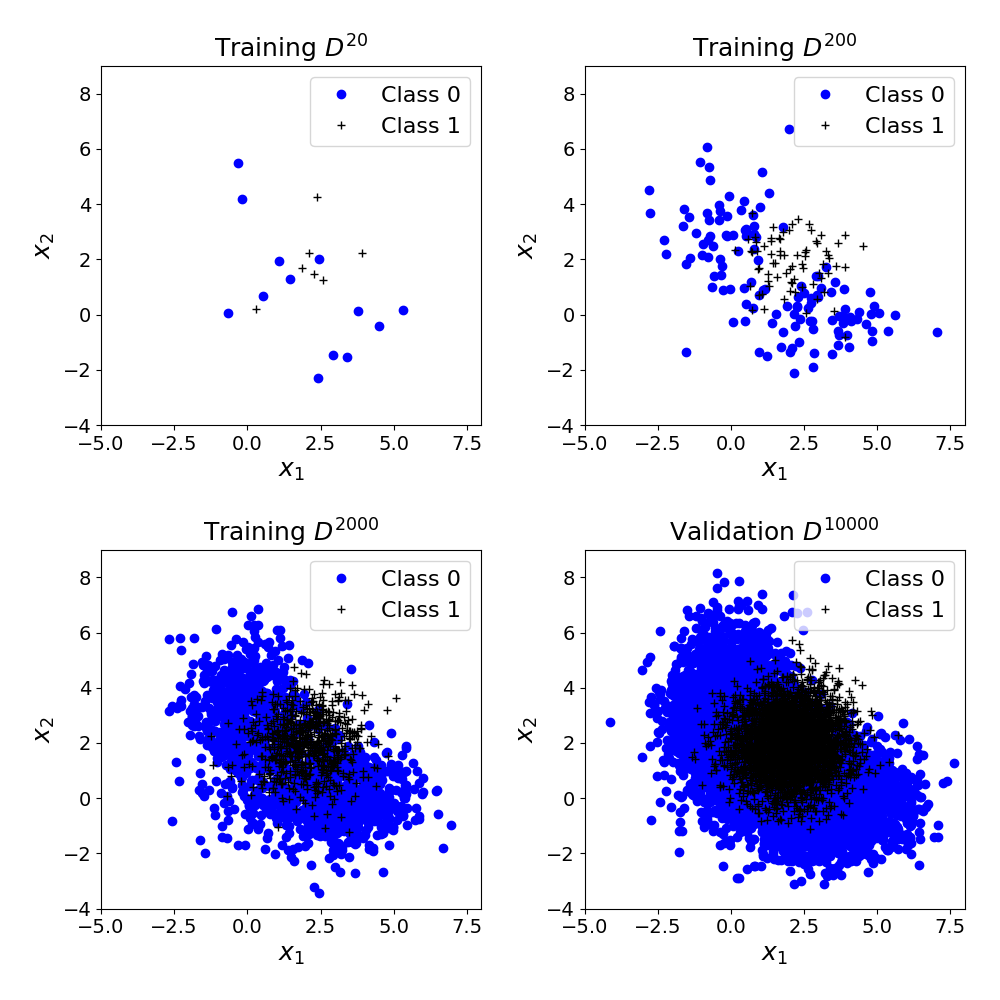

In [5]:
# Define distribution parameters: a, mu and Sigma
pdf = {}
pdf['priors'] = np.array([0.65, 0.35])
pdf['gmm_a'] = np.array([0.5, 0.5])  

pdf['mu'] = np.array([[3, 0],
                      [0, 3],
                      [2, 2]])  # Gaussian distributions means
pdf['Sigma'] = np.array([[[2, 0],
                          [0, 1]],
                         [[1, 0],
                          [0, 2]],
                         [[1, 0],
                          [0, 1]]])  # Gaussian distributions covariance matrices


    
# Number of training input samples for experiments
N_train = [20, 200, 2000]

# Plot the original data and their true labels
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Making lists for the samples and labels
X_train = []
labels_train = []
N_labels_train = []
# Index for axes
t = 0
for N_t in N_train:
    X_t, labels_t = generate_q1_data(N_t, pdf)
    X_train.append(X_t)

    labels_train.append(labels_t)
    N_labels_train.append(np.array((sum(labels_t == 0), sum(labels_t == 1))))

    # Axis fancy indexing for the sake of plotting correctly in subplots
    ax[floor(t/2), t%2].set_title(r"Training $D^{%d}$" % (N_t))
    ax[floor(t/2), t%2].plot(X_t[labels_t==0, 0], X_t[labels_t==0, 1], 'bo', label="Class 0")
    ax[floor(t/2), t%2].plot(X_t[labels_t==1, 0], X_t[labels_t==1, 1], 'k+', label="Class 1")
    ax[floor(t/2), t%2].set_xlabel(r"$x_1$")
    ax[floor(t/2), t%2].set_ylabel(r"$x_2$")
    ax[floor(t/2), t%2].legend()

    t += 1

# Number of validation samples for experiments
N_valid = 10000

X_valid, labels_valid = generate_q1_data(N_valid, pdf)

# Count up the number of samples per class
Nl_valid = np.array((sum(labels_valid == 0), sum(labels_valid == 1)))

ax[1, 1].set_title(r"Validation $D^{%d}$" % (N_valid))
ax[1, 1].plot(X_valid[labels_valid==0, 0], X_valid[labels_valid==0, 1], 'bo', label="Class 0")
ax[1, 1].plot(X_valid[labels_valid==1, 0], X_valid[labels_valid==1, 1], 'k+', label="Class 1")
ax[1, 1].set_xlabel(r"$x_1$")
ax[1, 1].set_ylabel(r"$x_2$")
ax[1, 1].legend()

# Using validation set samples to limit axes (most samples drawn, highest odds of spanning sample space)
x1_valid_lim = (floor(np.min(X_valid[:,0])), ceil(np.max(X_valid[:,0])))
x2_valid_lim = (floor(np.min(X_valid[:,1])), ceil(np.max(X_valid[:,1])))
# Keep axis-equal so there is new skewed perspective due to a greater range along one axis
plt.setp(ax, xlim=x1_valid_lim, ylim=x2_valid_lim)
plt.tight_layout()
plt.show()

### Part 1

Determine the theoretically optimal classifier that achieves minimum probability of error using knowledge of the true PDF. Specify the classifier mathematically and implement it; then apply it to all samples in $D_{valid}^{10K}$. From the decision results and true labels for this validation set, estimate and plot the ROC curve of this min-$\text{Pr}(\text{error})$ classifier. Report the optimal threshold and probability error estimate of the theoretical min-$\text{Pr}(\text{error})$ classifier, indicating on the ROC curve with a special marker its location. Also report the empirical threshold and associated minimum probability of error estimate for this classifier based on counts of decision-truth label pairs on $D_{valid}^{10K}$.

>The theoretically optimal classifier that achieves minimum probability of error is the <b>ERM classifier with 0-1 loss</b>, or the <b>Maximum a Posteriori (MAP) classifier</b>. Therefore, the decision rule for a two-class ERM classifier can be expressed as the following likelihood-ratio test:

\begin{equation*}
\frac{p(\mathbf{x}\,|\,L=1)}{p(\mathbf{x}\,|\,L=0)} \begin{matrix} \text{Decide 1} \\ ~~~~>~~~~ \\ ~~~~<~~~~ \\ \text{Decide 0} \end{matrix} \frac{(\lambda_{10} - \lambda_{00})}{(\lambda_{01} - \lambda_{11})} \frac{p(L=0)}{p(L=1)},
\end{equation*}

>where the distributions $p(x\,|\,L=j)$ and $p(L=j)$ for $j \in 0, 1$ are specified in the problem statement. 

>With <b>0-1 loss</b>, the decision rule reduces down to minimum probability of error (MAP) classification:

\begin{equation*}
\frac{p(\mathbf{x}\,|\,L=1)}{p(\mathbf{x}\,|\,L=0)} \begin{matrix} \text{Decide 1} \\ ~~~~>~~~~ \\ ~~~~<~~~~ \\ \text{Decide 0} \end{matrix} \frac{p(L=0)}{p(L=1)}.
\end{equation*}

>Hence the theoretically optimal threshold $\gamma^*$ that leads to minimum probability of error is given by:

\begin{equation*}
\gamma^* = \frac{p(L=0)}{p(L=1)} = \frac{0.65}{0.35} \approx \underline{1.857}.
\end{equation*}

>We can also express the decision threshold $\gamma^*$ by taking the logarithm of both sides of the above equation, leading to the equivalent decision rule:

\begin{equation*}
\ln p(\mathbf{x}\,|\,L=1) - \ln p(\mathbf{x}\,|\,L=0)  \begin{matrix} \text{Decide 1} \\ ~~~~>~~~~ \\ ~~~~<~~~~ \\ \text{Decide 0} \end{matrix} \ln \gamma^*.
\end{equation*}

>We will use this logarithm-based equivalent in the code snippet below to plot the ROC curve and report on the probability of error estimate.

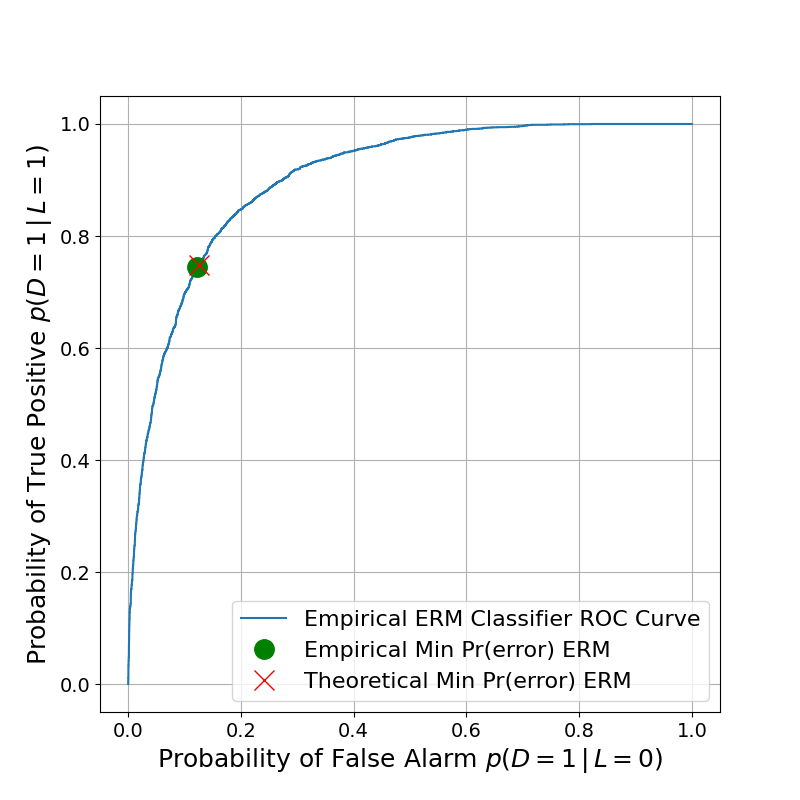

Min Empirical Pr(error) for ERM = 0.1690
Min Empirical Gamma = 1.910
Min Theoretical Pr(error) for ERM = 0.1694
Min Theoretical Gamma = 1.857


In [6]:
def discriminant_score_erm(X, dist_params):
    # Compute class conditional likelihoods to express ratio test, where ratio is discriminant score
    # Recall that there is a mixture weighting for class 0!
    class_lld_0 = (dist_params['gmm_a'][0]*mvn.pdf(X, dist_params['mu'][0], dist_params['Sigma'][0])
                   + dist_params['gmm_a'][1]*mvn.pdf(X, dist_params['mu'][1], dist_params['Sigma'][1]))
    class_lld_1 = mvn.pdf(X, dist_params['mu'][2], dist_params['Sigma'][2])

    # Class conditional log likelihoods equate to decision boundary log gamma in the 0-1 loss case
    erm_scores = np.log(class_lld_1) - np.log(class_lld_0)
    
    return erm_scores

disc_erm_scores = discriminant_score_erm(X_valid, pdf)
# Construct the ROC for ERM by changing log(gamma)
roc_erm, gammas_empirical = estimate_roc(disc_erm_scores, labels_valid, Nl_valid)
# roc_erm returns a np.array of shape(2, N+2) where N+2 are the number of thresholds
# and 2 rows are the FPR and TPR respectively

fig_roc, ax_roc = plt.subplots(figsize=(8, 8));

ax_roc.plot(roc_erm['p10'], roc_erm['p11'], label="Empirical ERM Classifier ROC Curve")
ax_roc.set_xlabel(r"Probability of False Alarm $p(D=1\,|\,L=0)$")
ax_roc.set_ylabel(r"Probability of True Positive $p(D=1\,|\,L=1)$")

# ROC returns FPR vs TPR, but prob error needs FNR so take 1-TPR
# Pr(error; γ) = p(D = 1|L = 0; γ)p(L = 0) + p(D = 0|L = 1; γ)p(L = 1)
prob_error_empirical = np.array((roc_erm['p10'], 1 - roc_erm['p11'])).T.dot(Nl_valid / N_valid)

# Min prob error for the empirically-selected gamma thresholds
min_prob_error_empirical = np.min(prob_error_empirical)
min_ind_empirical = np.argmin(prob_error_empirical)

# Compute theoretical gamma as log-ratio of priors (0-1 loss) -> MAP classification rule
gamma_map = pdf['priors'][0] / pdf['priors'][1]
decisions_map = disc_erm_scores >= np.log(gamma_map)

class_metrics_map = get_binary_classification_metrics(decisions_map, labels_valid, Nl_valid)
# To compute probability of error, we need FPR and FNR
min_prob_error_map = np.array((class_metrics_map['FPR'] * pdf['priors'][0] + 
                               class_metrics_map['FNR'] * pdf['priors'][1]))

# Plot theoretical and empirical
ax_roc.plot(roc_erm['p10'][min_ind_empirical], roc_erm['p11'][min_ind_empirical], 'go', label="Empirical Min Pr(error) ERM",
            markersize=14)
ax_roc.plot(class_metrics_map['FPR'], class_metrics_map['TPR'], 'rx', label="Theoretical Min Pr(error) ERM", markersize=14)

plt.grid(True)
plt.legend()
plt.show()

print("Min Empirical Pr(error) for ERM = {:.4f}".format(min_prob_error_empirical))
print("Min Empirical Gamma = {:.3f}".format(np.exp(gammas_empirical[min_ind_empirical])))

print("Min Theoretical Pr(error) for ERM = {:.4f}".format(min_prob_error_map))
print("Min Theoretical Gamma = {:.3f}".format(gamma_map))

<u>Optional:</u> As supplementary visualization, generate a plot of the decision boundary of this classification rule overlaid on the validation dataset. This establishes an aspirational performance level on the dataset for the following approximations.

>Recall from the [decision thresholds notebook](../erm_decision_theory/erm_decision_boundaries.ipynb) that the decision boundaries for our MAP classifier is when the LHS and RHS of the above likelihood-ratio test is equal. In other words, after rearranging:

\begin{equation*}
\ln p(\mathbf{x}\,|\,L=1) - \ln p(\mathbf{x}\,|\,L=0) - \ln \gamma^* = 0.
\end{equation*}

>We will now plot the decision boundaries on $D_{valid}^{10K}$ using this relation:

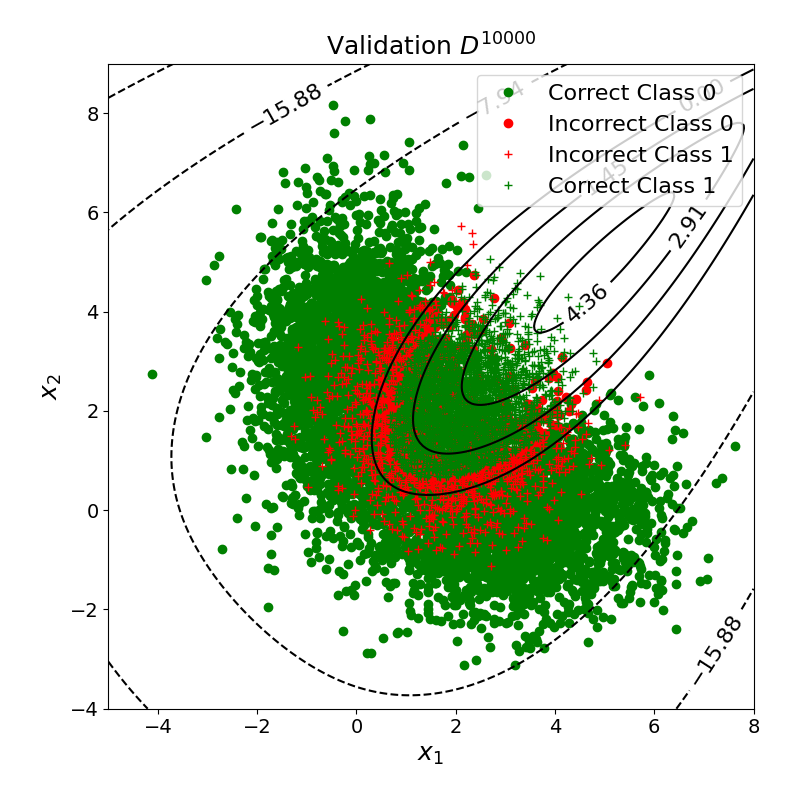

In [7]:
def plot_erm_decision_boundaries(ax, X, params, prediction_function, phi=None):
    bounds_X = (floor(np.min(X[:,0])), ceil(np.max(X[:,0])))
    bounds_Y = (floor(np.min(X[:,1])), ceil(np.max(X[:,1])))
    
    # Get grid coordinates and corresponding discriminant scores for the prediction function
    xx, yy, Z = create_prediction_score_grid(bounds_X, bounds_Y, params, prediction_function, phi)

    # The next four lines just determine how I'll draw contour lines at 9 discriminant score grid value levels
    equal_levels = np.array((0.3, 0.6, 0.9))
    min_Z = np.min(Z) * equal_levels[::-1] # Reversing the levels list [.9, .6, .3]
    max_Z = np.max(Z) * equal_levels
    contour_levels = min_Z.tolist() + [0] + max_Z.tolist()

    # Contour plot of decision boundaries
    cs = ax.contour(xx, yy, Z, contour_levels, colors='k')
    ax.clabel(cs, fontsize=16, inline=1)
    
# Defining new figure to plot the validation set samples with overlaid decision boundaries
fig_disc_grid, ax_disc = plt.subplots(figsize=(8, 8));

ax_disc.set_title(r"Validation $D^{%d}$" % (N_valid))
# class 0 circle, class 1 +, correct green, incorrect red
ax_disc.plot(X_valid[class_metrics_map['TN'], 0], X_valid[class_metrics_map['TN'], 1], 'og', label="Correct Class 0");
ax_disc.plot(X_valid[class_metrics_map['FP'], 0], X_valid[class_metrics_map['FP'], 1], 'or', label="Incorrect Class 0");
ax_disc.plot(X_valid[class_metrics_map['FN'], 0], X_valid[class_metrics_map['FN'], 1], '+r', label="Incorrect Class 1");
ax_disc.plot(X_valid[class_metrics_map['TP'], 0], X_valid[class_metrics_map['TP'], 1], '+g', label="Correct Class 1");
ax_disc.set_xlabel(r"$x_1$")
ax_disc.set_ylabel(r"$x_2$")

plot_erm_decision_boundaries(ax_disc, X_valid, pdf, discriminant_score_erm)

# Keep axis-equal so there is new skewed perspective due to a greater range along one axis
ax_disc.set_aspect('equal')
ax_disc.legend()
plt.tight_layout()
plt.show()

### Part 2

(a) Using the maximum likelihood parameter estimation technique train three separate logistic-linear approximations of class label posterior functions given a sample. For each approximation use one of the three training datasets $D_{train}^{20}$, $D_{train}^{200}$, $D_{train}^{2000}$. When optimizing the parameters, specify the optimization problem as minimization of the negative-log-likelihood (NLL) of the training dataset, and use your favorite numerical optimization approach, such as gradient descent or Python's `optimize.minimize` function in the scipy library.

>Our binary logistic regression model is specified as:

\begin{align*}
p(l \, | \, \mathbf{x}; \boldsymbol{\theta}) & = \text{Ber}\left(l \, | \, g(\mathbf{w}^\intercal \phi(\mathbf{x}))\right) \\
 & = g\left((\mathbf{w}^\intercal \phi(\mathbf{x})\right)^l \left(1-g(\mathbf{w}^\intercal \phi(\mathbf{x}))\right)^{(1-l)},
\end{align*}

>where $\phi(\mathbf{x})$ is a fixed transformation of the inputs and $l$ is the true label variable. The log-likelihood, $\text{LL}(\boldsymbol{\theta})$, for this binary classifier given a dataset with $N$ samples can then be written as:

\begin{equation*}
\text{LL}(\boldsymbol{\theta}) = \frac{1}{N} \sum_{i=1}^N \left[ {l^{(i)}} \log g\left(\mathbf{w}^\intercal \phi(\mathbf{x}^{(i)})\right) + (1-l^{(i)}) \log \left(1-g(\mathbf{w}^\intercal \phi(\mathbf{x}^{(i)}))\right) \right].
\end{equation*}

>Minimizing the $\text{NLL}(\boldsymbol{\theta})$ to derive the maximum likelihood estimate (MLE) for the model's parameters/weights $\boldsymbol{\theta}_\text{MLE}=\mathbf{w}^*$ is then framed as the following optimization problem:

\begin{align*}
\mathbf{w}^* = \mathop{\rm argmin}_\boldsymbol{\theta} \text{NLL}(\boldsymbol{\theta}) & = \mathop{\rm argmin}_\mathbf{w}  - \frac{1}{N} \sum_{i=1}^N \left[ {l^{(i)}} \log g\left(\mathbf{w}^\intercal \phi(\mathbf{x}^{(i)})\right) + (1-l^{(i)}) \log \left(1-g(\mathbf{w}^\intercal \phi(\mathbf{x}^{(i)}))\right) \right].
\end{align*}

>Let's begin by implementing our <b>sigmoid</b> function $g(z)$, a corresponding prediction function in matrix form as $g(\phi(\mathbf{X})\mathbf{w})$ for all $N$ examples, where the feature transformation $\phi(\cdot)$ occurs externally to the prediction function, and lastly a negative log-likelihood $\text{NLL}(\boldsymbol{\theta})$ loss function:

In [8]:
epsilon = 1e-7 # Epsilon; smallest positive floating value

# Define the logistic/sigmoid function
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

# Define the prediction function l = 1 / (1 + np.exp(-X*w))
# X.dot(w) inputs to the sigmoid referred to as logits
def logistic_prediction_prob(X, w):
    logits = X.dot(w)
    return sigmoid(logits)

# Binary cross entropy, equivalent to NLL in this context
def nll(labels, predictions):
    # Epsilon adjustment handles numerical errors by avoiding underflow or overflow
    predictions = np.clip(predictions, epsilon, 1 - epsilon)
    # log p(L=0 | x; theta)
    log_p0 = (1 - labels) * np.log(1 - predictions + epsilon)
    # log p(L=1 | x; theta)
    log_p1 = labels * np.log(predictions + epsilon)
    # NLL expression written above as the mean-summation of per-sample log-likelihoods
    return -np.mean(log_p0 + log_p1, axis=0)

>We can the derive optimal $\mathbf{w}^*$ using any numerical optimization approach, such as a second-order method available through [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html):

In [9]:
def compute_logistic_params(X, labels):
    """
    Calculates and returns the MLE of the parameter theta (w*) for a logistic-based model.
    """
    
    # Dimensionality including the addition of bias term
    theta0 = np.random.randn(X.shape[1])

    # Solve the optimization problem
    cost_fun = lambda w: nll(labels, logistic_prediction_prob(X, w))
    res = minimize(cost_fun, theta0, tol=1e-6)
    
    return res.x

>After obtaining $\mathbf{w}^*$, we can apply the logistic function to every transformed sample $\phi(\mathbf{x}^{(i)})$ in the validation dataset $D_{valid}^{10K}$, and make decisions according to the following rule:

\begin{equation*}
D(\mathbf{x}^{(i)}) = \begin{cases} 1 & \text{if} \; g\left(\mathbf{w}^{*\intercal} \phi(\mathbf{x}^{(i)})\right) \geq 0.5 \\ 0 & \text{otherwise} \end{cases}.
\end{equation*}

>This is derived from the fact that we choose class 1 when:

\begin{align*}
p(L=1 \, | \, \mathbf{x}; \boldsymbol{\theta}) > p(L=0 \, | \, \mathbf{x}; \boldsymbol{\theta}),
\end{align*}

>which is in the binary case when $p(L=1 \, | \, \mathbf{x}; \boldsymbol{\theta}) \geq 0.5$ or equivalently when $g(\mathbf{w}^{\intercal} \phi(\mathbf{x}^{(i)})) \geq 0.5$, as the logistic function outputs posterior probability of class 1 being true, hence the above decision rule $D(\mathbf{x})$.

Determine how to use these class-label-posterior approximations to classify a sample in order to approximate the minimum-$\text{Pr}(\text{error})$ classification rule; apply these three approximations of the class label posterior function on samples in $D_{valid}^{10K}$, and estimate the probability of error that these three classification rules will attain (using counts of decisions on the validation set).

>We have described above how to derive the optimal weights $\mathbf{w}^*$ for the binary logistic model's approximation of the class posteriors. Now we will determine probability of error estimates on the validation set $D_{valid}$ using model approximations trained with the three different $D_{train}$ datasets. First, a utility function is defined below to report on the correct vs incorrect classification performance of any given logistic regression model on this validation set; basically evaluating "generalization performance" of the trained model. <b>Note</b> how it takes an additional argument for transforming inputs $\mathbf{x}$ based on the $\phi(\cdot)$ function.

In [10]:
def report_logistic_classifier_results(ax, X, w, labels, N_labels, phi=None):
    """
    Report the probability of error and plot the classified data, plus predicted 
    decision contours of the logistic classifier applied to the phi-transformed data.
    """
    
    predictions = logistic_prediction_prob(phi.fit_transform(X), w)
        
    # Predicted decisions based on the default 0.5 threshold (higher probability mass on one side or the other)
    decisions = np.array(predictions >= 0.5)

    logistic_metrics = get_binary_classification_metrics(decisions, labels, N_labels)
    # To compute probability of error, we need FPR and FNR
    prob_error = np.array((logistic_metrics['FPR'], logistic_metrics['FNR'])).T.dot(N_labels / labels.shape[0])
    
    # Plot all decisions (green = correct, red = incorrect)
    ax.plot(X[logistic_metrics['TN'], 0], X[logistic_metrics['TN'], 1], 'og', label="Correct Class 0");
    ax.plot(X[logistic_metrics['FP'], 0], X[logistic_metrics['FP'], 1], 'or', label="Incorrect Class 0");
    ax.plot(X[logistic_metrics['FN'], 0], X[logistic_metrics['FN'], 1], '+r', label="Incorrect Class 1");
    ax.plot(X[logistic_metrics['TP'], 0], X[logistic_metrics['TP'], 1], '+g', label="Correct Class 1");
    
    # Get grid coordinates and corresponding probability scores for the prediction function
    # Draw the decision boundary based on the phi transformation of input features x
    # Re-use the bounds from the validation set's x1 and x2 axes (global variables)
    xx, yy, Z = create_prediction_score_grid(x1_valid_lim, x2_valid_lim, w, logistic_prediction_prob, phi)

    # Once reshaped as a grid, plot contour of probabilities per input feature (ignoring bias)
    cs = ax.contour(xx, yy, Z, levels=1, colors='k')
    
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    
    return prob_error

<u>Optional</u>: As supplementary visualization, generate plots of the decision boundaries of these trained classifiers superimposed on their respective training datasets and the validation dataset. 

#### Logistic-Linear Model

> Next, let's minimize the negative log-likelihood loss on the three different $D_{train}$ subsets using a <b>logistic-linear</b> model, $g(\mathbf{w}^\intercal \phi(\mathbf{x})) = 1/(1+e^{-\mathbf{w}^\intercal \phi(\mathbf{x})})$, with $\phi(\mathbf{x})=\begin{bmatrix}1,\mathbf{x}\end{bmatrix}^\intercal$ as the augmented input vector, $\mathbf{\tilde{x}}$. Below is the training procedure for this model:

Second-order optimization of the NLL loss for a logistic-linear model applied to different training subsets

Logistic-Linear N=20; MLE for w: [-1.81633873  0.28860475  0.42636828]
Training set error for the N=20 classifier is 0.300
Validation set error for the N=20 classifier is 0.354


Logistic-Linear N=200; MLE for w: [-2.20092546  0.4756795   0.5087787 ]
Training set error for the N=200 classifier is 0.340
Validation set error for the N=200 classifier is 0.346


Logistic-Linear N=2000; MLE for w: [-2.02973214  0.38351942  0.39696439]
Training set error for the N=2000 classifier is 0.339
Validation set error for the N=2000 classifier is 0.347




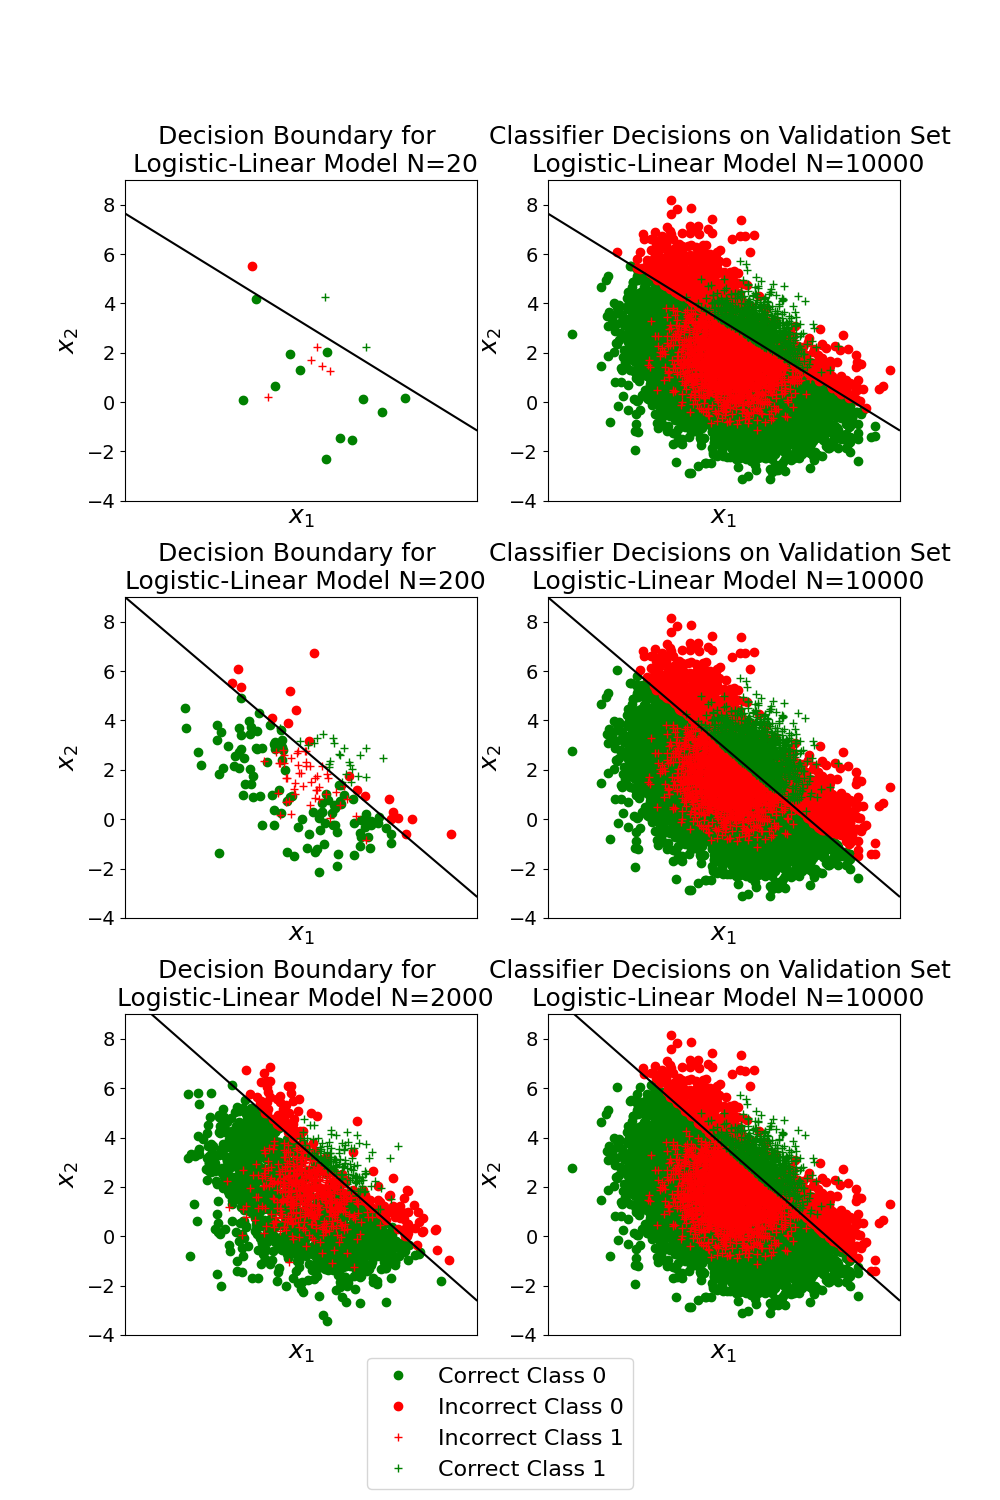

In [11]:
fig_linear, ax_linear = plt.subplots(3, 2, figsize=(10, 15));

# Define phi transformation to only include a bias column
phi = PolynomialFeatures(degree=1)

print("Second-order optimization of the NLL loss for a logistic-linear model applied to different training subsets\n")
for i in range(len(N_train)):
    w_mle = compute_logistic_params(phi.fit_transform(X_train[i]), labels_train[i])
    print("Logistic-Linear N={}; MLE for w: {}".format(N_train[i], w_mle))

    prob_error = report_logistic_classifier_results(
        ax_linear[i, 0], X_train[i], w_mle, labels_train[i], N_labels_train[i], phi)

    print("Training set error for the N={} classifier is {:.3f}".format(N_train[i], prob_error))
    ax_linear[i, 0].set_title("Decision Boundary for \n Logistic-Linear Model N={}".format(N_train[i]))
    ax_linear[i, 0].set_xticks([])

    prob_error = report_logistic_classifier_results(
        ax_linear[i, 1], X_valid, w_mle, labels_valid, Nl_valid, phi)
    ax_linear[i, 1].set_title("Classifier Decisions on Validation Set \n Logistic-Linear Model N={}".format(N_valid))
    print("Validation set error for the N={} classifier is {:.3f}\n\n".format(N_train[i], prob_error))
    ax_linear[i, 1].set_xticks([])

# Again use the most sampled subset (validation) to define x-y limits
plt.setp(ax_linear, xlim=x1_valid_lim, ylim=x2_valid_lim)

# Adjust subplot positions
plt.subplots_adjust(hspace=0.3)

# Super plot the legends
handles, labels = ax_linear[0, 1].get_legend_handles_labels()
fig_linear.legend(handles, labels, loc='lower center')

plt.show()

#### Logistic-Quadratic Model

Repeat the process using a logistic-quadratic-function approximation of class label posterior functions given a sample.

>For a <b>logistic-quadratic</b> model, we instead consider the logistic function $g(\mathbf{w}^\intercal \phi(\mathbf{x})) = 1/(1+e^{-\mathbf{w}^\intercal \phi(\mathbf{x})})$ with $\phi(\mathbf{x})=\begin{bmatrix}1,x_1,x_2,x_1^2,x_1x_2,x_2^2\end{bmatrix}^\intercal$. Below is the identical training procedure, with a quadratic feature transformation of the inputs:

Second-order optimization of the NLL loss for a logistic-quadratic model applied to different training subsets

Logistic-Quadratic N=20; MLE for w: [  1.92446992   5.22878964 -10.94860568  -2.51905275   5.05404109
  -0.07078647]
Training set error for the N=20 classifier is 0.050
Validation set error for the N=20 classifier is 0.294


Logistic-Quadratic N=200; MLE for w: [-2.6547348   1.83788812  1.60609523 -0.55478577  0.56222376 -0.52631124]
Training set error for the N=200 classifier is 0.130
Validation set error for the N=200 classifier is 0.177


Logistic-Quadratic N=2000; MLE for w: [-1.82447539  1.16994351  1.15784279 -0.43871743  0.54986398 -0.43531716]
Training set error for the N=2000 classifier is 0.164
Validation set error for the N=2000 classifier is 0.171




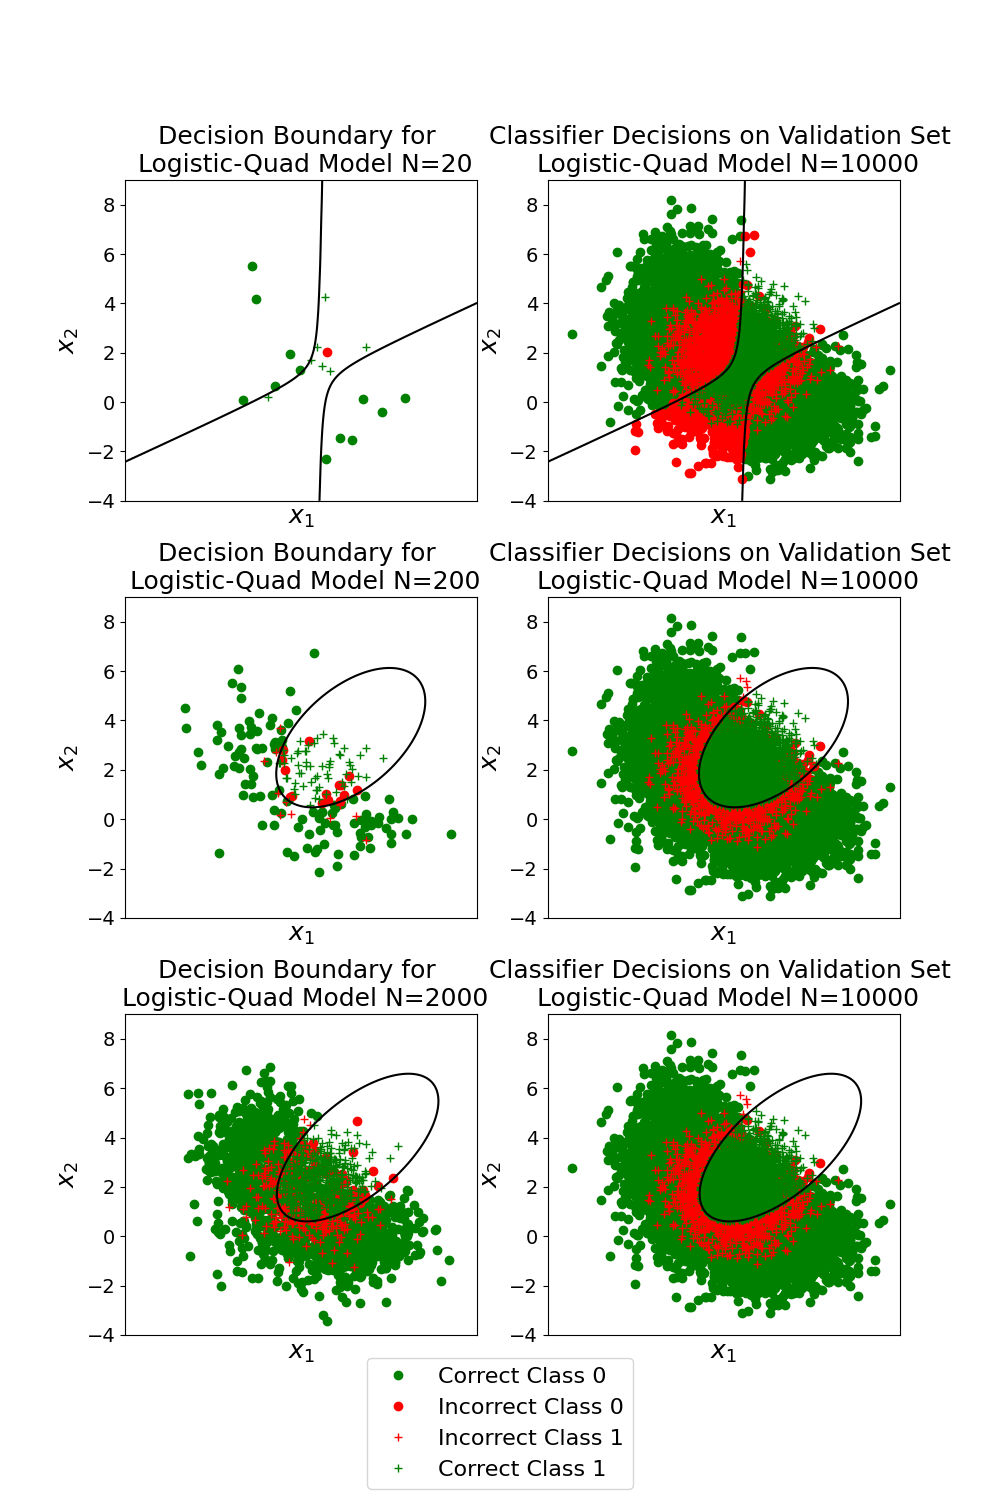

In [12]:
fig_quad, ax_quad = plt.subplots(3, 2, figsize=(10, 15));

# Define phi transformation to only include a bias column
phi = PolynomialFeatures(degree=2)

print("Second-order optimization of the NLL loss for a logistic-quadratic model applied to different training subsets\n")
for i in range(len(N_train)):
    w_mle = compute_logistic_params(phi.fit_transform(X_train[i]), labels_train[i])
    print("Logistic-Quadratic N={}; MLE for w: {}".format(N_train[i], w_mle))

    prob_error = report_logistic_classifier_results(
        ax_quad[i, 0], X_train[i], w_mle, labels_train[i], N_labels_train[i], phi)

    print("Training set error for the N={} classifier is {:.3f}".format(N_train[i], prob_error))
    ax_quad[i, 0].set_title("Decision Boundary for \n Logistic-Quad Model N={}".format(N_train[i]))
    ax_quad[i, 0].set_xticks([])

    prob_error = report_logistic_classifier_results(
        ax_quad[i, 1], X_valid, w_mle, labels_valid, Nl_valid, phi)
    ax_quad[i, 1].set_title("Classifier Decisions on Validation Set \n Logistic-Quad Model N={}".format(N_valid))
    print("Validation set error for the N={} classifier is {:.3f}\n\n".format(N_train[i], prob_error))
    ax_quad[i, 1].set_xticks([])

# Again use the most sampled subset (validation) to define x-y limits
plt.setp(ax_quad, xlim=x1_valid_lim, ylim=x2_valid_lim)

# Adjust subplot positions
plt.subplots_adjust(hspace=0.3)

# Super plot the legends
handles, labels = ax_quad[0, 1].get_legend_handles_labels()
fig_quad.legend(handles, labels, loc='lower center')

plt.show()

How does the performance of your classifiers trained in this part (<b>Part 2</b>) compare to each other considering differences in number of training samples and function form? How do they compare to the theoretically optimal classifier from <b>Part 1</b>? Briefly discuss results and insights.

> A few important insights can be drawn from these experiments. First, is that the decision boundary between the two overlapping Gaussians describing this dataset is <b>nonlinear</b>, and so it is our expectation that the logistic-linear regression model would perform worse than the logistic-quadratic and theoretically optimal classifiers. Using the theoretical classifier's performance on the validation set as a guideline, with $\text{Pr}(\text{error})\!=\!0.169$, then the logistic-linear classifier's error estimates of ${\sim}0.35$ across all trained models is significantly worse (by more than a factor of two). Furthermore, the linear decision boundaries illustrate how ineffective the classifier is at discriminating between these Gaussian class-conditional PDFs, regardless of the amount of data trained on (very similar performance on the validation set for the $D_{train}^{200}$ and $D_{train}^{2000}$ models).

> On the other hand, the logistic-quadratic regression model is a far superior match for this problem domain. In fact, the error estimate on the validation set for the $D_{train}^{2000}$ classifier is $\text{Pr}(\text{error})\!=\!0.171$, which is close to the aspirational performance of the theoretically optimal classifier. We can therefore conclude that a quadratic decision boundary is a suitable separation of the two class regions in this dataset, as we might anticipate given the quadratic form present in the exponent of the Gaussian class-conditional PDFs. 

> A final noteworthy observation is how the logistic-quadratic classifier benefits from the availability of data. In the $D_{train}^{20}$ setting, the quadratic model clearly overfits the training set by obtaining an unrealistically good error estimate, $0.05$, at the expense of underperforming on the validation set, $0.294$. However, as more data is supplied to the logistic-quadratic model for training, we find that the generalization gap reduces with the $D_{train}^{2000}$ model yielding similar error estimates on both the training and validation sets. These estimates were also the best results.

## Question 2

Assume that scalar-real $y \in \mathbb{R}$ and two-dimensional real vector $\mathbf{x} \in \mathbb{R}^2$ are related to each other according to $y=c(\mathbf{x},\mathbf{w})+\epsilon$, where $c(.,\mathbf{w})$ is a cubic polynomial in $\mathbf{x}$ with coefficients $\mathbf{w}$, and $\epsilon$ is a random Gaussian scalar with mean zero and $\sigma^2$-variance ($\epsilon \sim \mathcal{N}(0, \sigma^2)$).

Given a dataset $D = \{(\mathbf{x}^{(1)},y^{(1)}),\dots,(\mathbf{x}^{(N)},y^{(N)})\}$ with $N$ samples of $(\mathbf{x},y)$ pairs that are independent and identically distributed according to the model, derive two estimators for $\mathbf{w}$ using maximum-likelihood (ML) and maximum-a-posteriori (MAP) parameter estimation approaches.

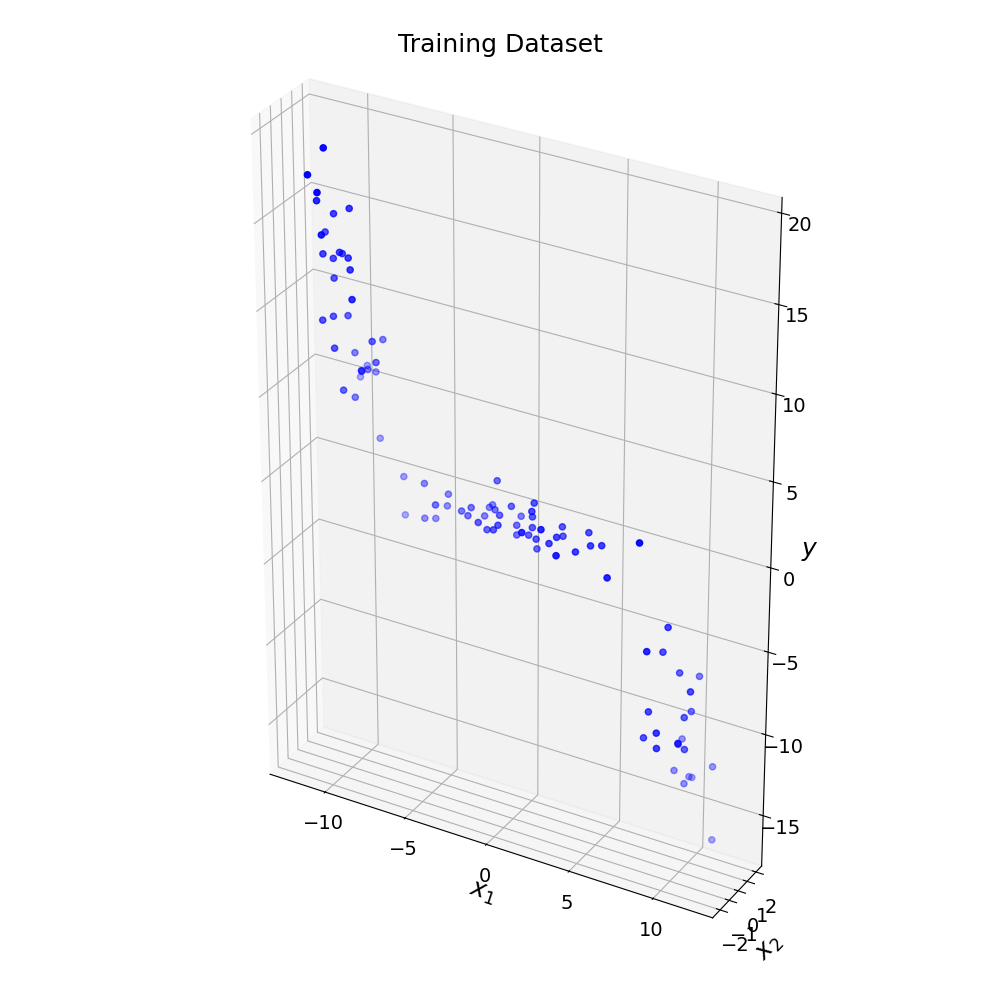

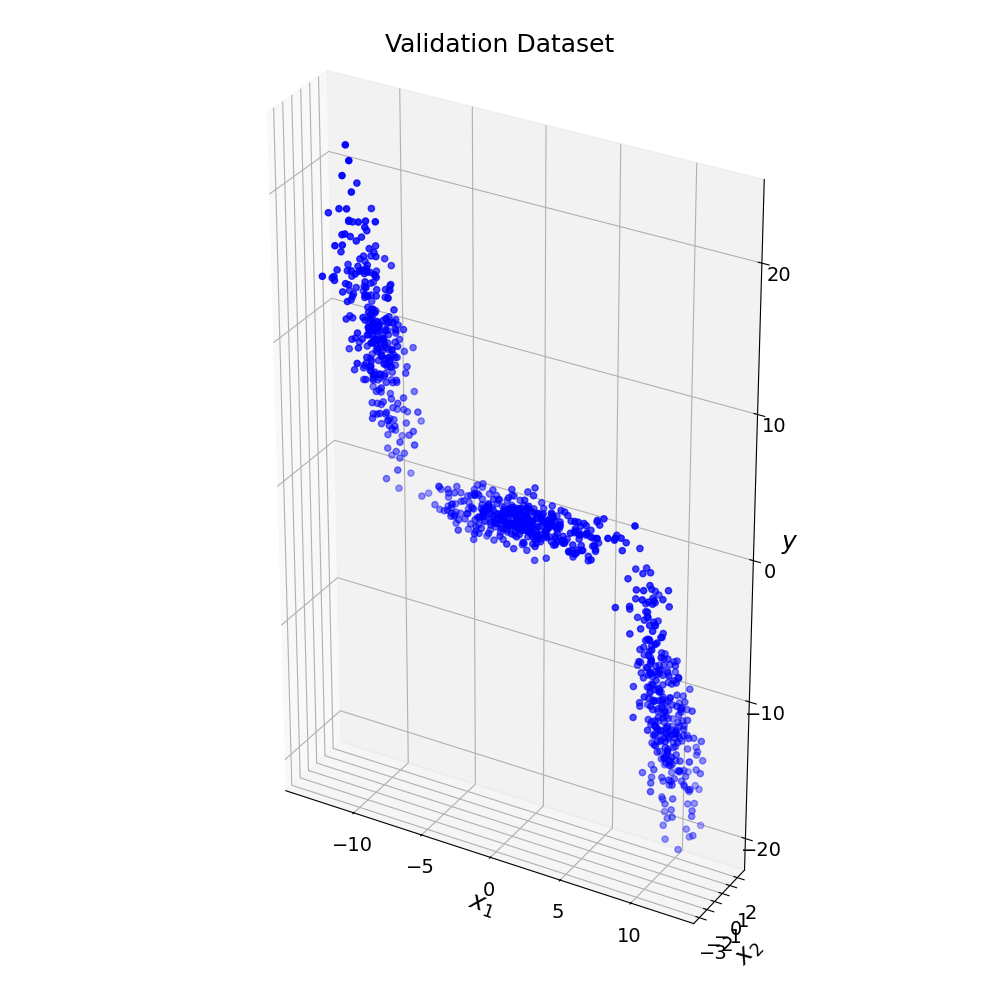

In [13]:
X_train, y_train = generate_q2_data(100, "Training")
X_valid, y_valid = generate_q2_data(1000, "Validation")

### ML Estimation

> Let's begin by defining the augmented features $\tilde{\mathbf{x}}$ for a two-dimensional real input vector and the corresponding regression weights $\mathbf{w}$ after applying a cubic polynomial $c(\mathbf{x},\mathbf{w})$ transformation:

\begin{equation*}
\tilde{\mathbf{x}} = \begin{bmatrix} 1 \\ x_1 \\ x_2 \\ x_1^2 \\ x_1 x_2 \\ x_2^2 \\ x_1^3 \\ x_1^2 x_2 \\ x_1 x_2^2 \\ x_2^3 \end{bmatrix} \in \mathbb{R}^{10}, \quad \quad  \mathbf{w} = \begin{bmatrix} w_0 \\ w_1 \\ w_2 \\ w_3 \\ w_4 \\ w_5 \\ w_6 \\ w_7 \\ w_8 \\ w_9 \end{bmatrix} \in \mathbb{R}^{10}.
\end{equation*}

> Now given our polynomial regression model $y = \mathbf{w}^\intercal \tilde{\mathbf{x}} + \epsilon$, our first step to performing ML parameter estimation is choosing a suitable parametric model, which we know for linear regression (still "linear" in the parameter space) is the conditional univariate Gaussian $p(y \, | \, \tilde{\mathbf{x}}; \boldsymbol{\theta}) = \mathcal{N}\big(y \, | \, \mathbf{w}^\intercal \mathbf{\tilde{x}}, \sigma^2 \big)$. Given a dataset $\mathcal{D}$ of $N$ iid samples, this can be expressed as:

\begin{equation*}
p(\mathcal{D} \, | \, \boldsymbol{\theta}) = \prod_{i=1}^N p(y^{(i)} \, | \, \tilde{\mathbf{x}}^{(i)} ; \boldsymbol{\theta}) = \prod_{i=1}^N \mathcal{N}\big(y^{(i)} \, | \, \mathbf{w}^\intercal \mathbf{\tilde{x}}^{(i)}, \sigma^2 \big),
\end{equation*}

> where $\boldsymbol{\theta} = \begin{bmatrix}\mathbf{w}, \sigma^2\end{bmatrix}^\intercal$. Assuming this model for our dataset, the ML estimator for the parameters $\hat{\boldsymbol{\theta}}_{\text{MLE}}$ is obtained by maximizing the log-likelihood of the data, or equivalently, minimizing negative log-likelihood (NLL):

\begin{align*}
\hat{\boldsymbol{\theta}}_{\text{MLE}} = \mathop{\rm argmin}_{\boldsymbol{\theta}} \text{NLL}(\boldsymbol{\theta}) & = \mathop{\rm argmin}_{\boldsymbol{\theta}} - \ln p(\mathcal{D} \, | \, \boldsymbol{\theta}) \\ & = \mathop{\rm argmin}_{\boldsymbol{\theta}} - \sum_{i=1}^N \ln p(y^{(i)} \, | \,\mathbf{\tilde{x}}^{(i)}; \boldsymbol{\theta}) \\
&= \mathop{\rm argmin}_{\boldsymbol{\theta}} -\sum_{i=1}^N \ln \left[ \left(\frac{1}{2\pi\sigma^2}\right)^{\frac{1}{2}} \exp \left(-\frac{1}{2\sigma^2}(y^{(i)} - \mathbf{w}^\intercal \mathbf{\tilde{x}}^{(i)})^2 \right) \right] \\
&= \mathop{\rm argmin}_{\boldsymbol{\theta}} \frac{N}{2}\ln(2\pi \sigma^2) + \frac{1}{2\sigma^2} \sum_{i=1}^N (y^{(i)} - \mathbf{w}^\intercal \mathbf{\tilde{x}}^{(i)})^2.
\end{align*}

>Assuming fixed variance, e.g. $\sigma^2 = 1$, we will focus on estimating $\mathbf{w}$ alone, resulting in an expression equal to the residual sum of squares (RSS) loss. For $\text{NLL}(\boldsymbol{\theta})$ where the regression weights $\mathbf{w}$ are our only parameters, then the derivative is:

\begin{equation*}
\nabla\text{NLL}_{\mathbf{w}}(\boldsymbol{\theta}) = \sum_{i=1}^N (y^{(i)} - \mathbf{w}^\intercal \mathbf{\tilde{x}}^{(i)})\mathbf{\tilde{x}}^{(i)} = \mathbf{X}^\intercal\mathbf{y} - \mathbf{X}^\intercal\mathbf{X} \mathbf{w},
\end{equation*}

>with $\mathbf{X}\in \mathbb{R}^{N\times 10}$ as the design matrix containing the transformed input features. Hence, the final ML estimator can be solved for by setting this gradient to zero and rearranging (assuming $\mathbf{X}^\intercal\mathbf{X}$ is invertible) to obtain:

\begin{equation*}
\hat{\boldsymbol{\theta}}_{\text{MLE}} = (\mathbf{X}^\intercal\mathbf{X})^{-1}\mathbf{X}^\intercal\mathbf{y} = \left(\sum_{i=1}^N \tilde{\mathbf{x}}^{(i)}\tilde{\mathbf{x}}^{(i)\intercal}\right)^{-1}\left(\sum_{i=1}^N \tilde{\mathbf{x}}^{(i)} y^{(i)}\right) = \mathbf{w}^*.
\end{equation*}

> Refer to the [ML notebook on linear regression](../linear_regression/lin_reg_mle.ipynb) for a reminder of these topics. 

> Below is the ML parameter estimator in code:

In [14]:
def mle_solution(X, y):
    # ML parameter solution is (X^T*X)^-1 * X^T * y 
    return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

### MAP Estimation

For the MAP estimator, assume that $\mathbf{w}$ has a zero-mean Gaussian prior with covariance matrix $\gamma \mathbf{I}$.

> We follow a similar routine to ML parameter estimation, except that the MAP parameter estimate $\hat{\boldsymbol{\theta}}_{\text{MAP}}$ adds a regularization term to the log-likelihood term, namely the log-prior:

\begin{align*}
\hat{\boldsymbol{\theta}}_{\text{MAP}} & = \mathop{\rm argmax}_{\boldsymbol{\theta}} \ln p(\boldsymbol{\theta}\, | \,\mathcal{D}) \\
& = \mathop{\rm argmax}_{\boldsymbol{\theta}} \ln p(\mathcal{D}\, | \,\boldsymbol{\theta}) + \ln p(\boldsymbol{\theta}),
\end{align*}

> where the prior on $\boldsymbol{\theta} = \mathbf{w}$ has been specified as $p(\boldsymbol{\theta}) = \mathcal{N}(\mathbf{w} \, | \, \mathbf{0}, \gamma \mathbf{I})$. The log of this PDF evaluates to:

\begin{align*} \ln p(\boldsymbol{\theta}) & = \ln \mathcal{N}(\mathbf{w} \, | \, \mathbf{0}, \gamma \mathbf{I}) \\
& = \ln \left[\frac{1}{(2\pi)^{\frac{n}{2}}|\gamma\mathbf{I}|^{\frac{1}{2}}} \exp \left(-\frac{1}{2}(\mathbf{w} - \mathbf{0})^\intercal (\gamma\mathbf{I})^{-1}(\mathbf{w} - \mathbf{0})\right)\right] \\
& = -\frac{n}{2}\ln(2\pi) - \frac{1}{2}\ln|\gamma\mathbf{I}| - \frac{1}{2}\mathbf{w}^\intercal (\gamma\mathbf{I})^{-1}\mathbf{w},
\end{align*}

> and after removing the terms independent of $\mathbf{w}$, plus knowing that $(\gamma\mathbf{I})^{-1}=\frac{1}{\gamma}\mathbf{I}$, we are left with $ \ln p(\boldsymbol{\theta}) = - \frac{1}{2\gamma}\mathbf{w}^\intercal \mathbf{w}.$

> Once again assuming fixed variance, $\sigma^2 = 1$, our regularized minimization problem for linear regression becomes:

\begin{align*} \hat{\boldsymbol{\theta}}_{\text{MAP}} & = \mathop{\rm argmin}_{\boldsymbol{\theta}} - \left[\ln p(\mathcal{D}\, | \,\boldsymbol{\theta}) + \ln p(\boldsymbol{\theta})\right] \\
& = \mathop{\rm argmin}_{\boldsymbol{\theta}} \frac{1}{2} \sum_{i=1}^N (y^{(i)} - \mathbf{w}^\intercal \mathbf{\tilde{x}}^{(i)})^2 + \frac{1}{2\gamma}\mathbf{w}^\intercal \mathbf{w}.
\end{align*}

> Thus to find the MAP parameter estimate $\hat{\boldsymbol{\theta}}_{\text{MAP}}$, we compute the derivate of the above loss objective:

\begin{align*} \nabla \left(-\ln p(\boldsymbol{\theta}\, | \,\mathcal{D})\right)_\mathbf{w} & = \frac{\delta}{\delta \mathbf{w}^\intercal} \left[\frac{1}{2} \sum_{i=1}^N (y^{(i)} - \mathbf{w}^\intercal \mathbf{\tilde{x}}^{(i)})^2 + \frac{1}{2\gamma}\mathbf{w}^\intercal \mathbf{w}\right] \\
& = \sum_{i=1}^N (y^{(i)} - \mathbf{w}^\intercal \mathbf{\tilde{x}}^{(i)})\mathbf{\tilde{x}}^{(i)} + \frac{1}{\gamma}\mathbf{w} \\
& = \mathbf{X}^\intercal\mathbf{X} \mathbf{w} - \mathbf{X}^\intercal\mathbf{y} + \frac{1}{\gamma}\mathbf{w}, 
\end{align*}

> which after setting to zero and performing a little rearrangement, provides us with our optimal MAP estimate for $\mathbf{w}$:

\begin{align*} \mathbf{X}^\intercal\mathbf{X} \mathbf{w} - \mathbf{X}^\intercal\mathbf{y} + \frac{1}{\gamma}\mathbf{w} & = \mathbf{0}, \\
(\mathbf{X}^\intercal\mathbf{X} + \frac{1}{\gamma}\mathbf{I})\mathbf{w} & = \mathbf{X}^\intercal\mathbf{y}, \\
\mathbf{w}^* & = (\mathbf{X}^\intercal\mathbf{X} + \frac{1}{\gamma}\mathbf{I})^{-1}\mathbf{X}^\intercal\mathbf{y} = \left(\sum_{i=1}^N \tilde{\mathbf{x}}^{(i)}\tilde{\mathbf{x}}^{(i)\intercal} + \frac{1}{\gamma}\mathbf{I}\right)^{-1}\left(\sum_{i=1}^N \tilde{\mathbf{x}}^{(i)} y^{(i)}\right) = \hat{\boldsymbol{\theta}}_{\text{MAP}}.
\end{align*}

> Below is the MAP parameter estimator in code:

In [15]:
def map_solution(X, y, gamma):
    # MAP parameter solution is (X^T*X + (1/gamma)*I)^-1 * X^T * y 
    return np.linalg.inv(X.T.dot(X) + (1 / gamma)*np.eye(X.shape[1])).dot(X.T).dot(y)

Having derived the estimator expressions, implement them in code and apply them to the dataset generated by the attached Python/Matlab script. Using the <i>training dataset</i> ($N_{train}=100$), obtain the ML estimator and the MAP estimator for a variety of $\gamma$ values ranging from $10^{-4}$ to $10^4$ (span a log scale). Evaluate each <i>trained</i> model by calculating the mean squared error (MSE) between the $y$ values in the <i>validation samples</i> ($N_{valid}=1000$) and model estimates of these using $c(.,\mathbf{w}_{train})$.

In [16]:
def mse(y_preds, y_true):
    # Residual error (X * theta) - y
    error = y_preds - y_true
    # Return MSE
    return np.mean(error ** 2)

>First apply the $c(.,\mathbf{w})$ feature transformation to the training set and obtain the ML estimator solution. Then let's plot the plane fit using our <b>multiple</b> ($n > 1$) linear regression model parameterized by $\boldsymbol{\theta}_{\text{MLE}}$, and report the MSE attained when applying this ML-trained model to the validation set. See the below code snippet for this implementation:

MSE on Validation set for ML parameter estimator: 4.636


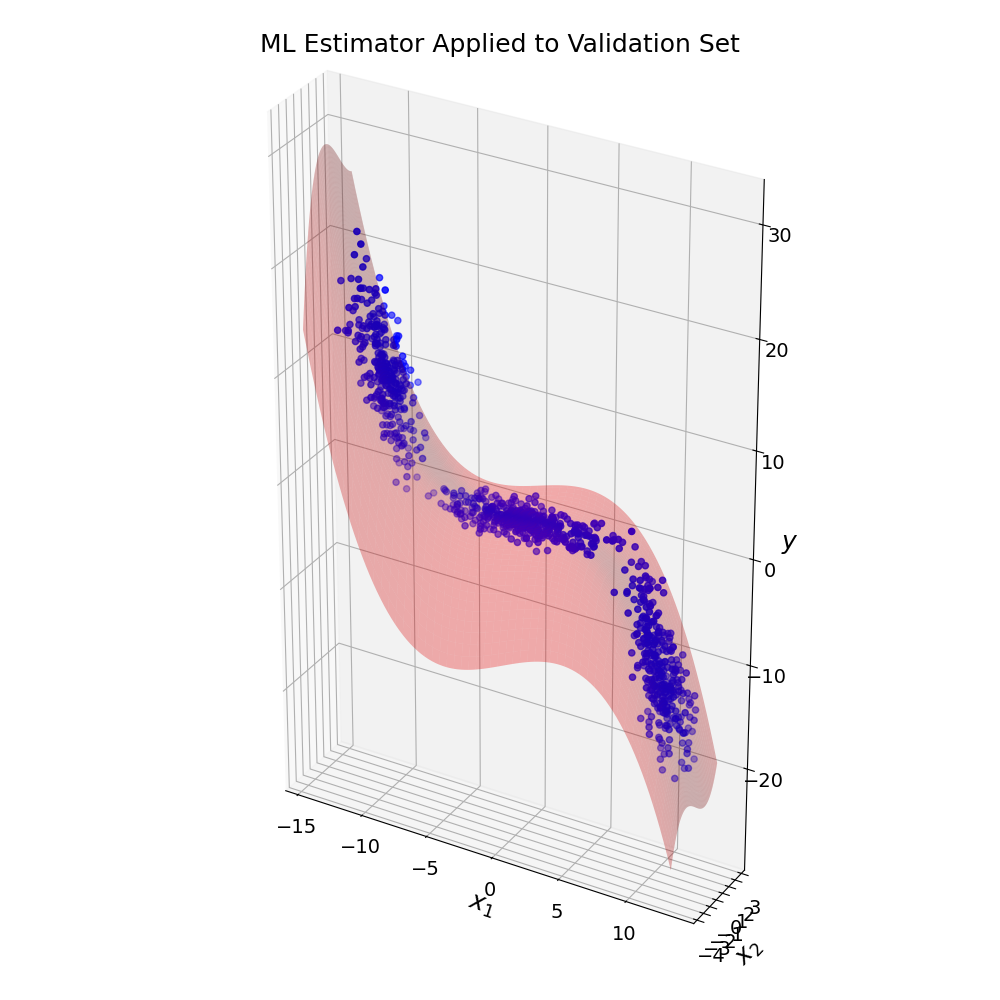

In [17]:
# First apply the cubic transformation of the inputs to the training set
phi = PolynomialFeatures(degree=3)
X_train_cubic = phi.fit_transform(X_train)

# Derive the MLE parameter solution
theta_mle = mle_solution(X_train_cubic, y_train)

# Then produce predictions on the validation samples using this ML estimator
X_valid_cubic = phi.transform(X_valid)
y_pred_mle = X_valid_cubic.dot(theta_mle)

mse_mle = mse(y_pred_mle, y_valid)
print("MSE on Validation set for ML parameter estimator: %.3f" % mse_mle)

x1_valid_lim = (floor(np.min(X_valid[:,0])), ceil(np.max(X_valid[:,0])))
x2_valid_lim = (floor(np.min(X_valid[:,1])), ceil(np.max(X_valid[:,1])))
# Regression model prediction function to feed into grid creation routine
reg_fun = lambda X, th: X.dot(th)
xx, yy, Z = create_prediction_score_grid(x1_valid_lim, x2_valid_lim, theta_mle, reg_fun, phi, num_coords=100)


fig_mle = plt.figure(figsize=(10, 10))
ax_mle = plt.axes(projection ='3d')

# Plot the best fit plane on the 2D real vector samples
ax_mle.scatter(X_valid[:,0], X_valid[:,1], y_valid, marker='o', color='b');
ax_mle.plot_surface(xx, yy, Z, color='red', alpha=0.3);
ax_mle.set_xlabel(r"$x_1$")
ax_mle.set_ylabel(r"$x_2$")
ax_mle.set_zlabel(r"$y$")

# To set the axes equal for a 3D plot
ax_mle.set_box_aspect((np.ptp(X_valid[:,0]), np.ptp(X_valid[:,1]), np.ptp(y_valid)))

plt.title("ML Estimator Applied to Validation Set")
plt.tight_layout()
plt.show()

>Now repeat the same process for the MAP estimator $\boldsymbol{\theta}_{\text{MAP}}$ applied to the validation set, but varying the $\gamma$ values from $10^{-7}$ to $10^7$ (spanning a log scale) to produce multiple MSE scores against labels $y_{valid}$. The question actually asked for the range $10^{-4}$ to $10^4$, but let's span a wider scale to simply illustrate where the best-performing $\gamma$ is located. See below for reference code and a plot of this trade-off between $\gamma$ and MSE:

Best MSE on Validation set for MAP parameter estimator with gamma=0.000002 is: 4.388


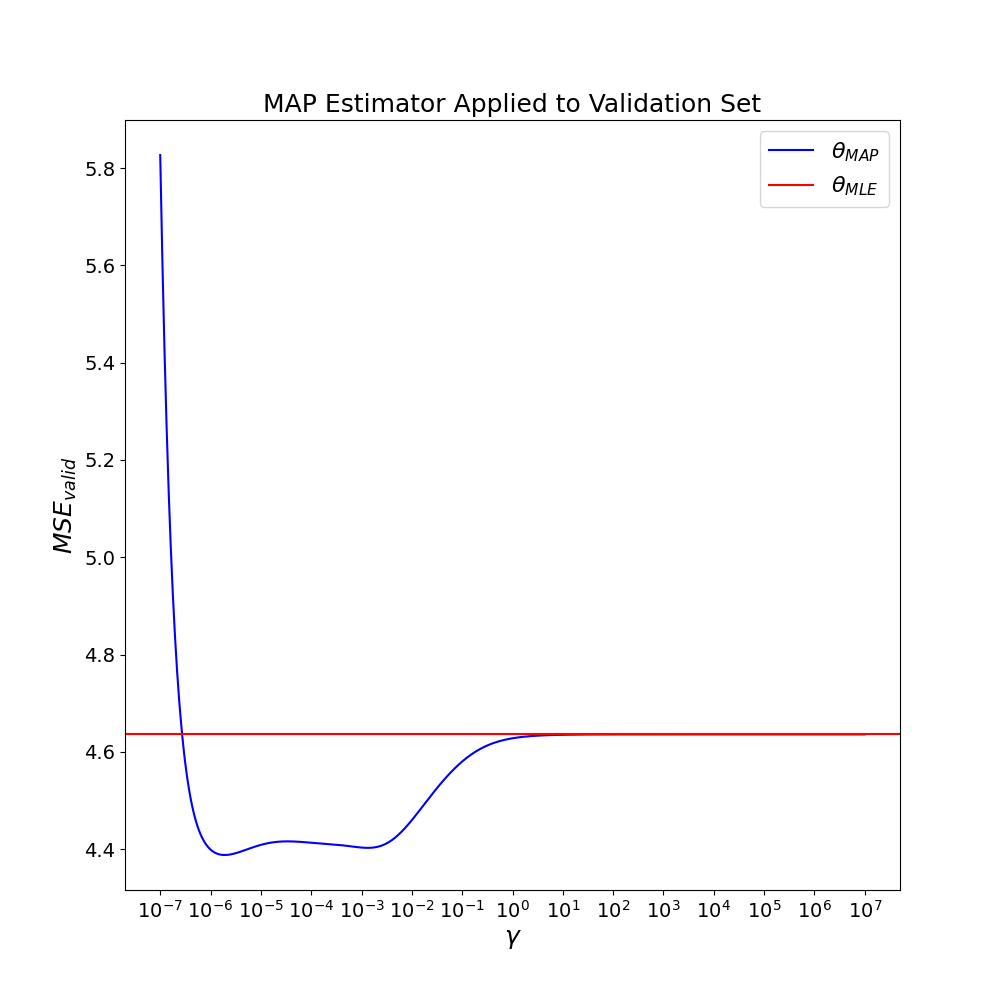

In [18]:
# Use geomspace to return 1000 evenly spaced numbers on a log scale with start-end points specified
n_gammas = 1000
# Gammas in the range 10^-7 to 10^7
gammas = np.geomspace(10**-7, 10**7, num=n_gammas)
mse_map = np.empty(n_gammas)
for i, gamma in enumerate(gammas):
    theta_map = map_solution(X_train_cubic, y_train, gamma)
    y_pred_map = X_valid_cubic.dot(theta_map)
    mse_map[i] = mse(y_pred_map, y_valid)

print(r"Best MSE on Validation set for MAP parameter estimator with gamma=%f is: %.3f" 
      % (gammas[np.argmin(mse_map)], np.min(mse_map)))

# Plot MSE vs regularizer parameter gamma
fig_map, ax_map = plt.subplots(figsize=(10, 10))
ax_map.plot(gammas, mse_map, color='b', label=r"$\theta_{MAP}$")
plt.axhline(y=mse_mle, xmin=10**-7, xmax=10**7, color='red', label=r"$\theta_{MLE}$")

ax_map.set_xscale('log')
ax_map.set_xticks(np.geomspace(10**-7, 10**7, num=15))

ax_map.set_xlabel(r"$\gamma$")
ax_map.set_ylabel(r"$MSE_{valid}$")
ax_map.set_title("MAP Estimator Applied to Validation Set")

plt.legend()
plt.show()

How does your MAP-trained model perform on the validation set as $\gamma$ is varied? How is the MAP estimate related to the ML estimate? Describe your experiments, visualize and quantify your analyses with data from these experiments.

>A MAP-trained linear regression model with a zero-mean Gaussian prior on the weights $\mathbf{w}$ is also known as <b>ridge regression</b>. The benefit of employing this parameter estimation technique is that it combats the precarious issue of <b>overfitting</b>, which MLE is susceptible to, especially in low $N$ sample size settings like ours ($N=100$ for model fitting is not a lot). It achieves this by adding an explicit term to penalize large weight magnitudes, thereby constraining the solution weights vector from taking on arbitrarily complex values. Consider the penalized NLL objective:

\begin{align*}
\text{PNLL}(\boldsymbol{\theta}) & = \frac{1}{2} \sum_{i=1}^N (y^{(i)} - \mathbf{w}^\intercal \mathbf{\tilde{x}}^{(i)})^2 + \lambda \sum_{j=1}^n w_j^2 \\
 & = \frac{1}{2} (\mathbf{X}\mathbf{w} - \mathbf{y})^\intercal (\mathbf{X}\mathbf{w} - \mathbf{y}) + \lambda \mathbf{w}^\intercal \mathbf{w},
\end{align*}

>where the parameter $\lambda=\frac{1}{\gamma}$ controls the degree or strength of regularization. 

>In regards to performance of the two estimators, as measured by MSE, we find that the MAP estimator for the polynomial regression model can lead to a much better solution when provided with an appropriate $\gamma$ value. This is demonstrated in our experiments, where the ML estimator has an MSE on the validation set of approximately $4.636$, whilst the MAP estimator obtains an MSE of $4.388$ for an optimal $\gamma^*=2\times 10^{-6}$.

>So what is the relationship between these two estimators and how does the regularization parameter $\gamma$ plays a role? From our plot of MSE vs $\gamma$, we observe that at larger values $\gamma > 10^1$ the MAP estimator converges to a similar result as that of the ML estimator. This is because as $\gamma$ tends towards infinity, the prior's variance approaches zero and the posterior distribution over the parameters becomes like an infinitely narrow "spike" around the ML point estimate. In other words, the posterior distribution is entirely determined by the likelihood of the data and MAP becomes equivalent to ML. When $\gamma$ is too large (or $\lambda$ too small), the optimization objective focuses entirely on maximizing likelihood of the data and may result in <b>overfitting</b>... but what about when $\gamma$ is too small? As we can see from our plot, when $\gamma < 3 \times 10^{-7}$ there is a drastic increase in MSE. This is because the posterior distribution learnt now focuses on staying too close to the prior and is not taking into account any of the available data, causing <b>underfitting</b>.

>Although we found a suitable value of $\gamma$ through this experiment, we may not always have enough data to create a validation set for hyperparameter selection. Note that if $\gamma$ was selected based on this validation set, then we could no longer use this same subset of data to evaluate generalization performance, as our model would provide a biased prediction estimate. Instead, one can stick to only using the training set by employing cross-validation to select this regularization strength parameter. This is exactly the task of [one of the questions in the following assignment](hw3.ipynb#Question-2). 